# Imports

In [2]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [ ]:
images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [ ]:
images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

## Load Test Set

In [ ]:
images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('gdrive/MyDrive/Colab Notebooks/archive/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [13]:
# pre-process data 
def scale_pixels(train, val, test):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm

X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)

# Plot Diagnostics

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [15]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## Create CNN Model with Batch Normalization

In [21]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [16]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/8
157/157 [==============================] - 3455s 22s/step - loss: 0.6558 - accuracy: 0.6013 - val_loss: 0.5946 - val_accuracy: 0.6140
Epoch 2/8
157/157 [==============================] - 3447s 22s/step - loss: 0.5704 - accuracy: 0.7042 - val_loss: 0.5572 - val_accuracy: 0.7410
Epoch 3/8
157/157 [==============================] - 3448s 22s/step - loss: 0.4715 - accuracy: 0.8128 - val_loss: 0.3247 - val_accuracy: 0.8665
Epoch 4/8
157/157 [==============================] - 3462s 22s/step - loss: 0.3452 - accuracy: 0.8625 - val_loss: 0.2812 - val_accuracy: 0.8910
Epoch 5/8
157/157 [==============================] - 3451s 22s/step - loss: 0.2749 - accuracy: 0.8865 - val_loss: 0.2620 - val_accuracy: 0.9005
Epoch 6/8
157/157 [==============================] - 3469s 22s/step - loss: 0.2480 - accuracy: 0.8963 - val_loss: 0.1850 - val_accuracy: 0.9215
Epoch 7/8
157/157 [==============================] - 3482s 22s/step - loss: 0.2101 - accuracy: 0.9117 - val_loss: 0.1681 - val_accuracy:

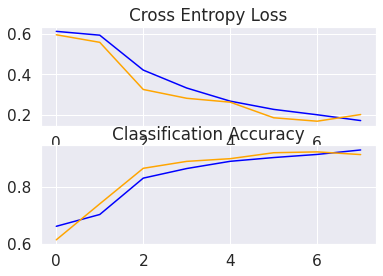

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 8)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/50
157/157 [==============================] - 128s 572ms/step - loss: 0.6076 - accuracy: 0.6713 - val_loss: 0.4448 - val_accuracy: 0.8385
Epoch 2/50
157/157 [==============================] - 86s 545ms/step - loss: 0.4280 - accuracy: 0.8172 - val_loss: 0.3888 - val_accuracy: 0.8525
Epoch 3/50
157/157 [==============================] - 86s 548ms/step - loss: 0.3162 - accuracy: 0.8780 - val_loss: 0.2648 - val_accuracy: 0.8935
Epoch 4/50
157/157 [==============================] - 85s 542ms/step - loss: 0.2782 - accuracy: 0.8882 - val_loss: 0.3530 - val_accuracy: 0.8595
Epoch 5/50
157/157 [==============================] - 85s 543ms/step - loss: 0.2643 - accuracy: 0.8938 - val_loss: 0.3404 - val_accuracy: 0.8630
Epoch 6/50
157/157 [==============================] - 85s 543ms/step - loss: 0.2138 - accuracy: 0.9132 - val_loss: 0.1975 - val_accuracy: 0.9305
Epoch 7/50
157/157 [==============================] - 85s 543ms/step - loss: 0.1816 - accuracy: 0.9265 - val_loss: 0.1544 - val_a

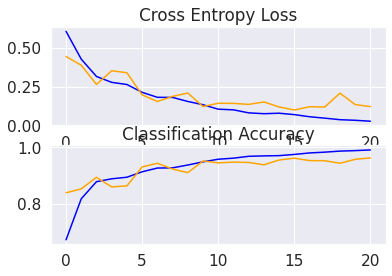

In [9]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 50)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/50
157/157 [==============================] - 127s 568ms/step - loss: 0.6498 - accuracy: 0.6176 - val_loss: 0.5891 - val_accuracy: 0.7635
Epoch 2/50
157/157 [==============================] - 86s 551ms/step - loss: 0.5408 - accuracy: 0.7444 - val_loss: 0.5696 - val_accuracy: 0.6530
Epoch 3/50
157/157 [==============================] - 86s 551ms/step - loss: 0.4878 - accuracy: 0.7803 - val_loss: 0.4339 - val_accuracy: 0.8195
Epoch 4/50
157/157 [==============================] - 87s 552ms/step - loss: 0.4232 - accuracy: 0.8245 - val_loss: 0.3607 - val_accuracy: 0.8660
Epoch 5/50
157/157 [==============================] - 87s 552ms/step - loss: 0.4077 - accuracy: 0.8247 - val_loss: 0.5723 - val_accuracy: 0.6655
Epoch 6/50
157/157 [==============================] - 87s 553ms/step - loss: 0.4100 - accuracy: 0.8205 - val_loss: 0.3370 - val_accuracy: 0.8695
Epoch 7/50
157/157 [==============================] - 87s 552ms/step - loss: 0.3506 - accuracy: 0.8572 - val_loss: 0.3658 - val_a

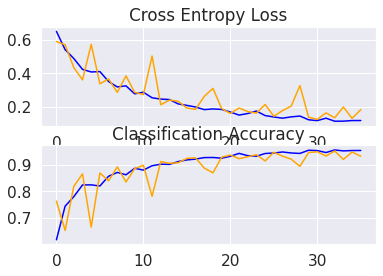

In [17]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.0001, 50)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [22]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
157/157 [==============================] - 33s 202ms/step - loss: 0.2572 - accuracy: 0.9051 - val_loss: 2.5511 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 30s 193ms/step - loss: 0.1124 - accuracy: 0.9615 - val_loss: 1.1405 - val_accuracy: 0.5525
Epoch 3/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0789 - accuracy: 0.9750 - val_loss: 0.5460 - val_accuracy: 0.7590
Epoch 4/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0610 - accuracy: 0.9826 - val_loss: 0.1131 - val_accuracy: 0.9550
Epoch 5/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0468 - accuracy: 0.9889 - val_loss: 0.1209 - val_accuracy: 0.9585
Epoch 6/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0332 - accuracy: 0.9947 - val_loss: 0.1411 - val_accuracy: 0.9495
Epoch 7/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0272 - accuracy: 0.9958 - val_loss: 0.0958 - val_ac

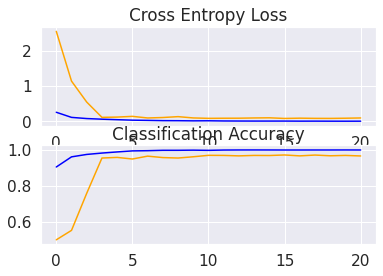

In [23]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 32s 196ms/step - loss: 0.1993 - accuracy: 0.9273 - val_loss: 3.5540 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0910 - accuracy: 0.9655 - val_loss: 1.3095 - val_accuracy: 0.5365
Epoch 3/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.2687 - val_accuracy: 0.8845
Epoch 4/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.2931 - val_accuracy: 0.8870
Epoch 5/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0271 - accuracy: 0.9925 - val_loss: 0.1028 - val_accuracy: 0.9590
Epoch 6/75
157/157 [==============================] - 31s 199ms/step - loss: 0.0149 - accuracy: 0.9970 - val_loss: 0.0747 - val_accuracy: 0.9720
Epoch 7/75
157/157 [==============================] - 30s 193ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.0904 - val_ac

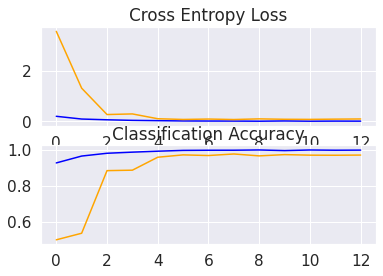

In [24]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [1]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=8, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 50)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))